# Experiments on Haar Features

In [1]:
import sys; sys.path.insert(0, '..')

import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from skimage.feature import draw_haar_like_feature

from database.dataset import *
from mc_candidate_proposal.hough_mc import HoughCalcificationDetection
from mc_candidate_proposal.morphology_mc import MorphologyCalcificationDetection
from feature_extraction.feature_extraction import CandidatesFeatureExtraction
import feature_extraction.haar_features.haar_modules as hm
from general_utils.utils import get_an_example_array
from general_utils.plots import draw_our_haar_like_features
from matplotlib.ticker import StrMethodFormatter, NullFormatter
from mc_candidate_proposal.candidate_utils import balance_candidates
from metrics.metrics_utils import get_tp_fp_fn_center_patch_criteria
from pathlib import Path

### Database initialization

In [2]:
def sort_relevances(feat_importances):
    """ Get the mean importance for each feature across the runs and then sort
    them in decreasing order.
    """
    feature_importances_array = np.asarray(feat_importances)
    mean_feature_importances_array = np.mean(feature_importances_array, axis=0)
    sorted_features = np.argsort(mean_feature_importances_array)[::-1]
    sorted_mean_feature_importance = mean_feature_importances_array[sorted_features]
    return sorted_features, sorted_mean_feature_importance

In [3]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    partitions=['train', 'validation'],
    max_lesion_diam_mm=None,
    cropped_imgs=True,
    use_muscle_mask=True,
    lesion_types=['calcification', 'cluster'],
    keep_just_images_of_lesion_type = False
)

In [4]:
THISPATH = Path('__file__').resolve()
data_path = THISPATH.parent.parent.parent/'data'
rbd_path = data_path/'gsm_imgs'

detector = 'gsm'
if detector == 'hough':
    hd = HoughCalcificationDetection(filter_muscle_region=True)
elif detector == 'gsm':
    hd = MorphologyCalcificationDetection(
        rbd_img_path=rbd_path, threshold=0.95, min_distance=6, area=14*14,
        store_intermediate=True, filter_muscle_region=True
    )

### Instantiate Candidate Proposals Detector and Features Extractor

In [5]:
# Feature extractor
haar_params = {
    'skimage': {
        'feature_type': None, 'feature_coord': None
    },
    'ours': {
        'horizontal_feature_types': [(hm.Feature4h, 1, 4), (hm.Feature4v, 4, 1), (hm.Feature3h3v, 3, 3)],
        'rotated_feature_types': None,
        'horizontal_feature_selection': None,
        'rotated_feature_selection': None,
    },
    'patch_size': 14
}
cfe  = CandidatesFeatureExtraction(patch_size=14, fos=False, haar_params=haar_params)

### Analysis of our selection

In [6]:
# Load classifiers from disk
folds = 5
path = (Path.cwd().parent.parent / f'data/haar_models_{detector}/')
our_features_clfs = []
for k in range(folds):
    filename = f'RF_our_{k}.sav'
    with open(str(path / filename), 'rb') as f:
        cl = pickle.load(f)
    our_features_clfs.append(cl)
# Load the feature importances for each classifier
feat_importances = []
for cl in our_features_clfs:
    feat_importances.append(cl.feature_importances_)

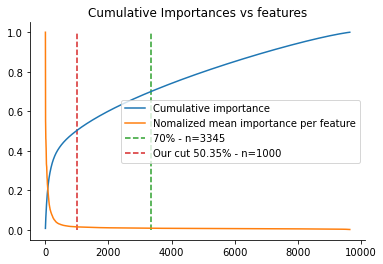

In [7]:
sorted_features, mean_importance = sort_relevances(feat_importances)
OUR_CUT = 1000

# Get the cumulative importances to analize the global percentage that we are keeping
cdf_feature_importances = np.cumsum(mean_importance/mean_importance.max())
cdf_feature_importances /= cdf_feature_importances.max()
sig_feature_count = np.count_nonzero(cdf_feature_importances < 0.70)
our_cut_importance = cdf_feature_importances[OUR_CUT]

cmap = plt.get_cmap("tab10")

plt.title('Cumulative Importances vs features')
plt.plot(cdf_feature_importances, label='Cumulative importance', c=cmap(0))
plt.plot(mean_importance/mean_importance.max(), label='Nomalized mean importance per feature', c=cmap(1))
plt.vlines(sig_feature_count, 0, 1, color=cmap(2), ls='--', label=f'70% - n={sig_feature_count}' )
plt.vlines(OUR_CUT, 0, 1, color=cmap(3), ls='--', label=f'Our cut {(our_cut_importance*100):.2f}% - n={OUR_CUT}')
sns.despine()
plt.legend()
plt.show()

### Analysis of skimage selection

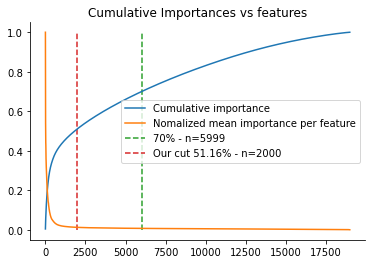

In [8]:
# Load classifiers from disk
folds = 5
path = (Path.cwd().parent.parent / f'data/haar_models_{detector}/')
our_features_clfs = []
for k in range(folds):
    filename = f'RF_skimage_{k}.sav'
    with open(str(path / filename), 'rb') as f:
        cl = pickle.load(f)
    our_features_clfs.append(cl)

# Load the feature importances for each classifier
feat_importances = []
for cl in our_features_clfs:
    feat_importances.append(cl.feature_importances_)

sorted_features, mean_importance = sort_relevances(feat_importances)
OUR_CUT = 2000

# Get the cumulative importances to analize the global percentage that we are keeping
cdf_feature_importances = np.cumsum(mean_importance/mean_importance.max())
cdf_feature_importances /= cdf_feature_importances.max()
sig_feature_count = np.count_nonzero(cdf_feature_importances < 0.70)
our_cut_importance = cdf_feature_importances[OUR_CUT]

cmap = plt.get_cmap("tab10")

plt.title('Cumulative Importances vs features')
plt.plot(cdf_feature_importances, label='Cumulative importance', c=cmap(0))
plt.plot(mean_importance/mean_importance.max(), label='Nomalized mean importance per feature', c=cmap(1))
plt.vlines(sig_feature_count, 0, 1, color=cmap(2), ls='--', label=f'70% - n={sig_feature_count}' )
plt.vlines(OUR_CUT, 0, 1, color=cmap(3), ls='--', label=f'Our cut {(our_cut_importance*100):.2f}% - n={OUR_CUT}')
sns.despine()
plt.legend()
plt.show()

### Analysis of combined selection

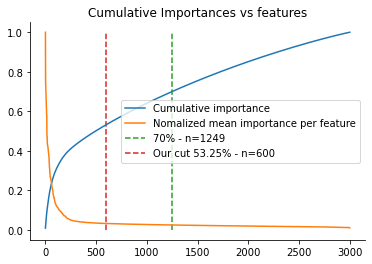

In [9]:
# Load classifiers from disk
folds = 5
path = (Path.cwd().parent.parent / f'data/haar_models_{detector}/')
our_features_clfs = []
for k in range(folds):
    filename = f'RF_all_{k}.sav'
    with open(str(path / filename), 'rb') as f:
        cl = pickle.load(f)
    our_features_clfs.append(cl)

# Load the feature importances for each classifier
feat_importances = []
for cl in our_features_clfs:
    feat_importances.append(cl.feature_importances_)

sorted_features, mean_importance = sort_relevances(feat_importances)
OUR_CUT = 600

# Get the cumulative importances to analize the global percentage that we are keeping
cdf_feature_importances = np.cumsum(mean_importance/mean_importance.max())
cdf_feature_importances /= cdf_feature_importances.max()
sig_feature_count = np.count_nonzero(cdf_feature_importances < 0.70)
our_cut_importance = cdf_feature_importances[OUR_CUT]

cmap = plt.get_cmap("tab10")

plt.title('Cumulative Importances vs features')
plt.plot(cdf_feature_importances, label='Cumulative importance', c=cmap(0))
plt.plot(mean_importance/mean_importance.max(), label='Nomalized mean importance per feature', c=cmap(1))
plt.vlines(sig_feature_count, 0, 1, color=cmap(2), ls='--', label=f'70% - n={sig_feature_count}' )
plt.vlines(OUR_CUT, 0, 1, color=cmap(3), ls='--', label=f'Our cut {(our_cut_importance*100):.2f}% - n={OUR_CUT}')
sns.despine()
plt.legend()
plt.show()

IGNORE THIS FOR NOW
Evaluate the influence of the number of features

In [10]:
path = (Path.cwd().parent.parent / f'data/haar_models_{detector}/')

aupr_test = pd.read_csv(path/'aupr_test_all_sorted.csv', index_col=0)
cols = aupr_test.columns
aupr_test.reset_index(drop=False, inplace=True)
aupr_test = pd.melt(aupr_test, id_vars=['index'], value_vars=cols)

aucs_test = pd.read_csv(path/'aucs_test_all_sorted.csv', index_col=0)
cols = aucs_test.columns
aucs_test.reset_index(drop=False, inplace=True)
aucs_test =pd.melt(aucs_test, id_vars=['index'], value_vars=cols)

aupr_train = pd.read_csv(path/'aupr_train_all_sorted.csv', index_col=0)
cols = aupr_train.columns
aupr_train.reset_index(drop=False, inplace=True)
aupr_train = pd.melt(aupr_train, id_vars=['index'], value_vars=cols)

aucs_train = pd.read_csv(path/'auc_train_all_sorted.csv', index_col=0)
cols = aucs_train.columns
aucs_train.reset_index(drop=False, inplace=True)
aucs_train =pd.melt(aucs_train, id_vars=['index'], value_vars=cols)

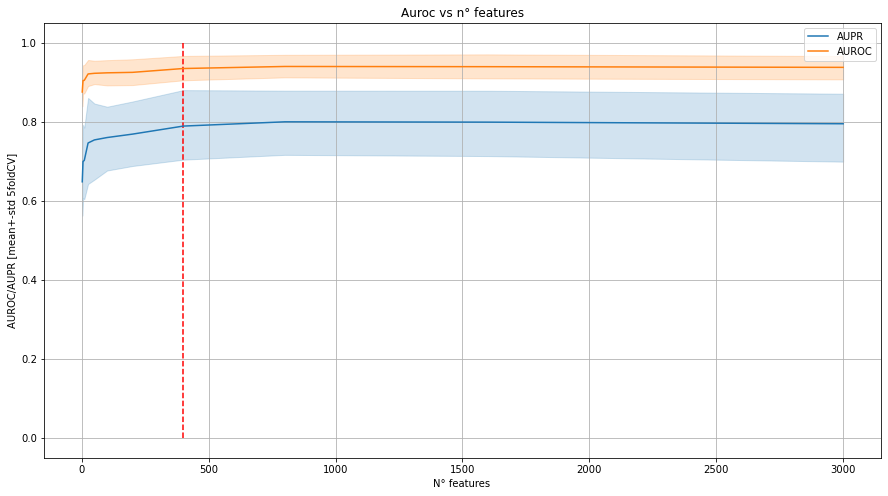

In [11]:
cmap = plt.get_cmap("tab10")
fig, ax = plt.subplots(1,1, figsize=(15,8))
ax.set_title('Auroc vs n° features')
sns.lineplot(x = aupr_test.variable.values.astype(int), y = aupr_test.value, ax=ax, color=cmap(0), label='AUPR')
sns.lineplot(x = aucs_test.variable.values.astype(int), y = aucs_test.value, ax=ax, color=cmap(1), label='AUROC')
ax.set_xlabel('N° features ')
ax.set_ylabel('AUROC/AUPR [mean+-std 5foldCV]')
plt.vlines(x=400, ymin=0, ymax=1, ls='--', color='r')
plt.legend()
plt.grid('on')

In [12]:
OUR_CUT = 500

# Final feature Selection and visualization

In [13]:
data = pd.read_feather(
        Path.cwd().parent.parent / f'data/haar_features_{detector}/all_cases_all_features_10to1_3000_selection.fth')

Run one feature extraction if you haven't (notebook reestarted for example) in order to have the feature objects in the feature extrator

In [14]:
idx = 0
# Get image to process
db_sample = db[idx]
image = db_sample['img']
image_id = db.df.iloc[idx].img_id
muscle_mask = db_sample['muscle_mask']
image_mask = db_sample['lesion_mask']
# candidate detection
candidates = hd.detect(image, image_id, muscle_mask=muscle_mask)
tp, fp, fn, ignored_candidates = get_tp_fp_fn_center_patch_criteria(candidates, image_mask, None, 14)
candidates = pd.concat([tp, fp], axis=0, ignore_index=True)
X = cfe.extract_features(candidates.loc[:,['x','y','radius']].values.astype(int), image)
del X, tp, fp, fn, muscle_mask, image_id

TIFFOpen: /home/jseia/Desktop/ml-dl/data/gsm_imgs/20587054.tiff: No such file or directory.


Visualize 48 most important features

In [15]:
selected_feats_48 = data.columns.values[sorted_features[:48].astype(int)]
skimage_feats_idxs_48 = [int(i.lstrip('haar_')) for i in selected_feats_48 if ('haar' in i) and ('rot' not in i) and ('hor' not in i)]
hor_feats_idxs_48 = [int(i.lstrip('hor_haar_')) for i in selected_feats_48 if ('haar' in i) and ('hor' in i)]
rot_feats_idxs_48 = [int(i.lstrip('rot_haar_')) for i in selected_feats_48 if ('haar' in i) and ('rot' in i)]

In [26]:
images = utils.get_an_example_array(image, 14, candidates.loc[:,['x','y','radius']].values.astype(int))

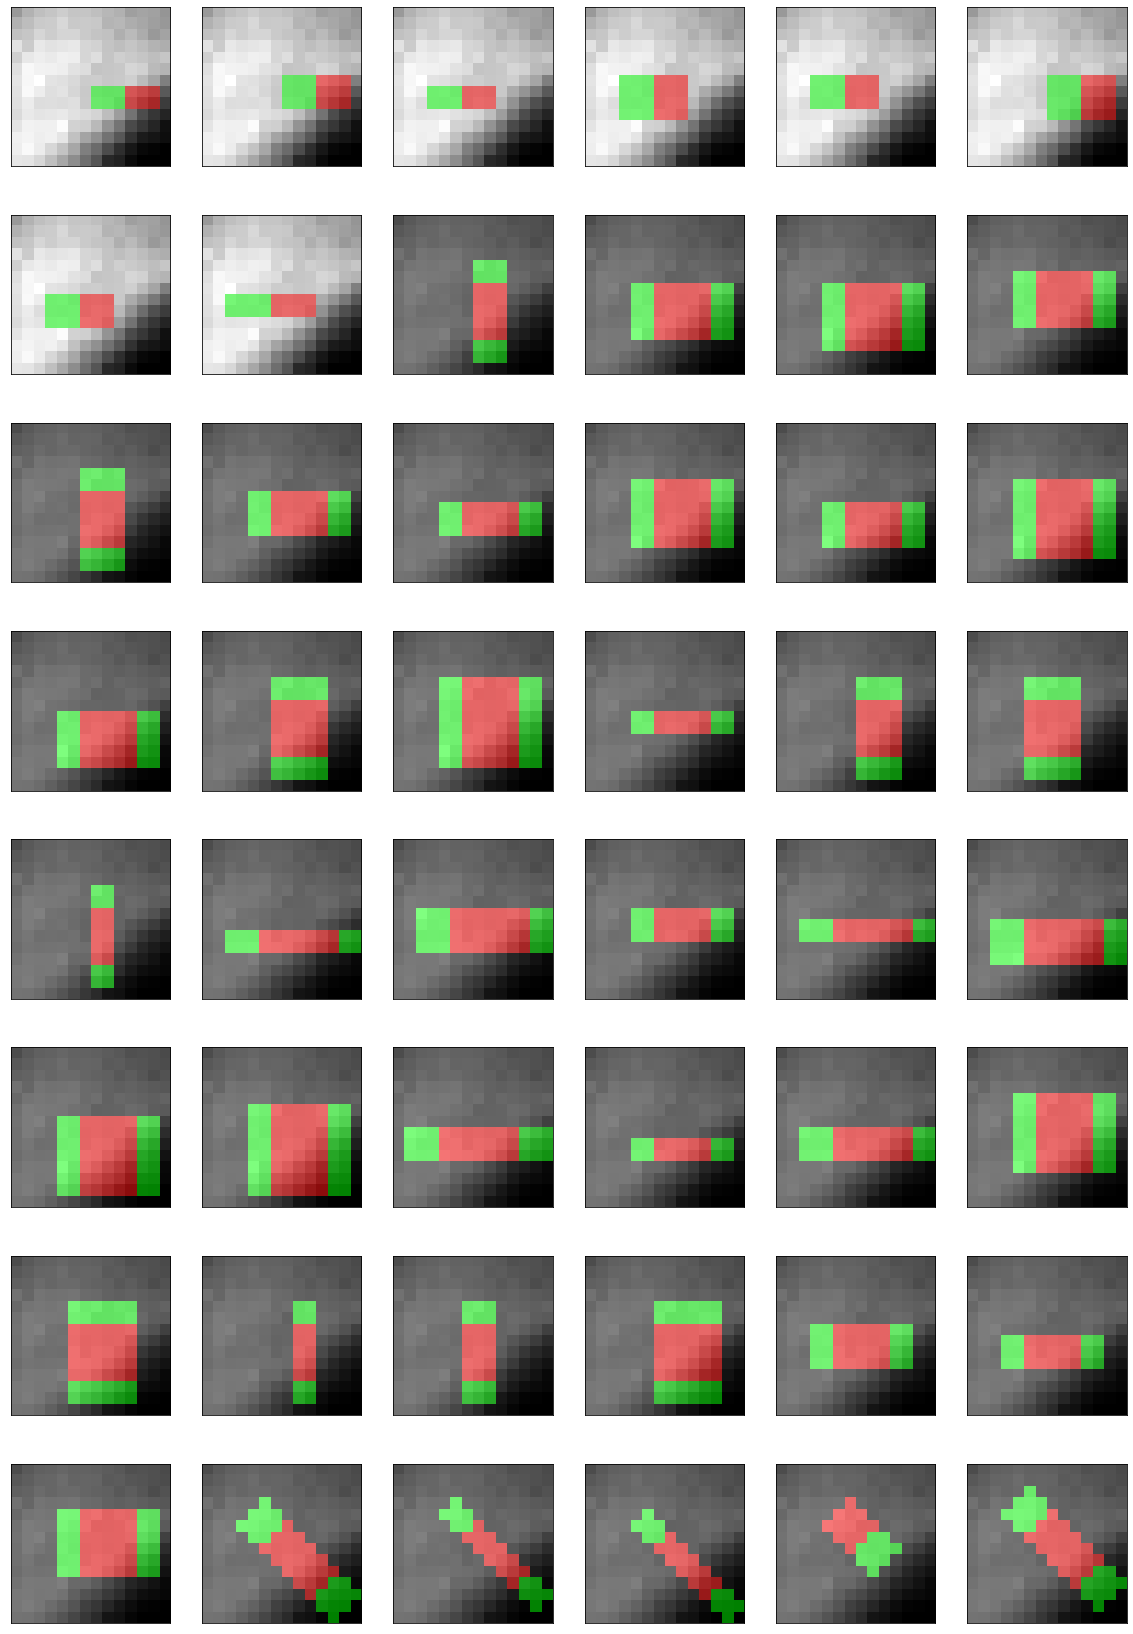

In [27]:
fig, axs = plt.subplots(8, 6, figsize=(20,30))
for idx, ax in enumerate(axs.ravel()):
    img = utils.min_max_norm(images[0], 1.).astype('float')
    if idx < len(skimage_feats_idxs_48):
        img = draw_haar_like_feature(
            img, 0, 0, images.shape[2], images.shape[1], [cfe.skimage_haar_feature_coords[skimage_feats_idxs_48[idx]]]
        )
    elif idx < len(skimage_feats_idxs_48)+len(hor_feats_idxs_48):
        index = idx - len(skimage_feats_idxs_48)
        img = draw_our_haar_like_features(img, cfe.our_haar_feature_types_h[hor_feats_idxs_48[index]], rot=False)
    else:
        index = idx - len(skimage_feats_idxs_48) - len(hor_feats_idxs_48)
        img = draw_our_haar_like_features(img, cfe.our_haar_feature_types_r[rot_feats_idxs_48[index]], rot=False)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

Select the final ones and save

In [28]:
selected_feats = data.columns.values[sorted_features[:OUR_CUT].astype(int)]
skimage_feats_idxs = [int(i.lstrip('haar_')) for i in selected_feats if ('haar' in i) and ('rot' not in i) and ('hor' not in i)]
hor_feats_idxs = [int(i.lstrip('hor_haar_')) for i in selected_feats if ('haar' in i) and ('hor' in i)]
rot_feats_idxs = [int(i.lstrip('rot_haar_')) for i in selected_feats if ('haar' in i) and ('rot' in i)]

In [29]:
selection = {}
selection['skimage_haar_feature_coords_sel'] = cfe.skimage_haar_feature_coords[skimage_feats_idxs]
selection['skimage_haar_feature_types_sel'] = cfe.skimage_haar_feature_types[skimage_feats_idxs]
selection['hor_feats_selection'] = np.asarray(cfe.our_haar_feature_types_h)[hor_feats_idxs]
selection['rot_feats_selection'] = np.asarray(cfe.our_haar_feature_types_r)[rot_feats_idxs]

path = (Path.cwd().parent.parent / f'data/haar_models_{detector}/')
with open(path/f'final_feat_selection_{detector}.p', 'wb') as f:
    pickle.dump(selection, f)

path = (Path.cwd().parent / f'data')
with open(path/f'final_haar_{OUR_CUT}_feat_selection_{detector}.p', 'wb') as f:
    pickle.dump(selection, f)

# Loading most discriminative haar features

Time comparison

In [30]:
# Feature extractor
haar_params = {
    'skimage': {
        'feature_type': None, 'feature_coord': None
    },
    'ours': {
        'horizontal_feature_types': [(hm.Feature4h, 1, 4), (hm.Feature4v, 4, 1), (hm.Feature3h3v, 3, 3)],
        'rotated_feature_types': None,
        'horizontal_feature_selection': None,
        'rotated_feature_selection': None,
    },
    'patch_size': 14
}
cfe_all  = CandidatesFeatureExtraction(patch_size=30, fos=False, haar_params=haar_params)

# ISTANTIATE the candidate Feature Extractor with the selected features.
haar_params = {
    'skimage': {
        'feature_type': selection['skimage_haar_feature_types_sel'],
        'feature_coord': selection['skimage_haar_feature_coords_sel']
    },
    'ours': {
        'horizontal_feature_selection': selection['hor_feats_selection'].tolist(),
        'rotated_feature_selection': selection['rot_feats_selection'].tolist(),
        'rotated_feature_types': None,
        'horizontal_feature_types': None
    },
    'patch_size': 14
}
cfe_sel  = CandidatesFeatureExtraction(patch_size=14, fos=False, haar_params=haar_params)

In [31]:
import time
db_sample = db[0]
image = db_sample['img']
image_id = db_sample['img_id']
image_mask = db_sample['lesion_mask']
muscle_mask = db_sample['muscle_mask']

# candidate detection
candidates = hd.detect(image, image_id, muscle_mask=muscle_mask)

# feature extraction
start = time.time()
X = cfe_all.extract_features(candidates, image)
time_all = time.time()- start

# feature extraction
start = time.time()
X = cfe_sel.extract_features(candidates, image)
time_sel = time.time()- start

print(f'time all: {time_all}    -    time selection: {time_sel}')
print(f'time all: {time_all/len(candidates)}    -    time selection: {time_sel/len(candidates)}')

TIFFOpen: /home/jseia/Desktop/ml-dl/data/gsm_imgs/20587054.tiff: No such file or directory.


time all: 67.01558113098145    -    time selection: 5.635035514831543
time all: 0.060049803880807745    -    time selection: 0.005049314977447619


visualize the features

In [32]:
images = utils.get_an_example_array(image, 14, candidates.astype(int))# candidates.loc[:,['x','y','radius']].values)

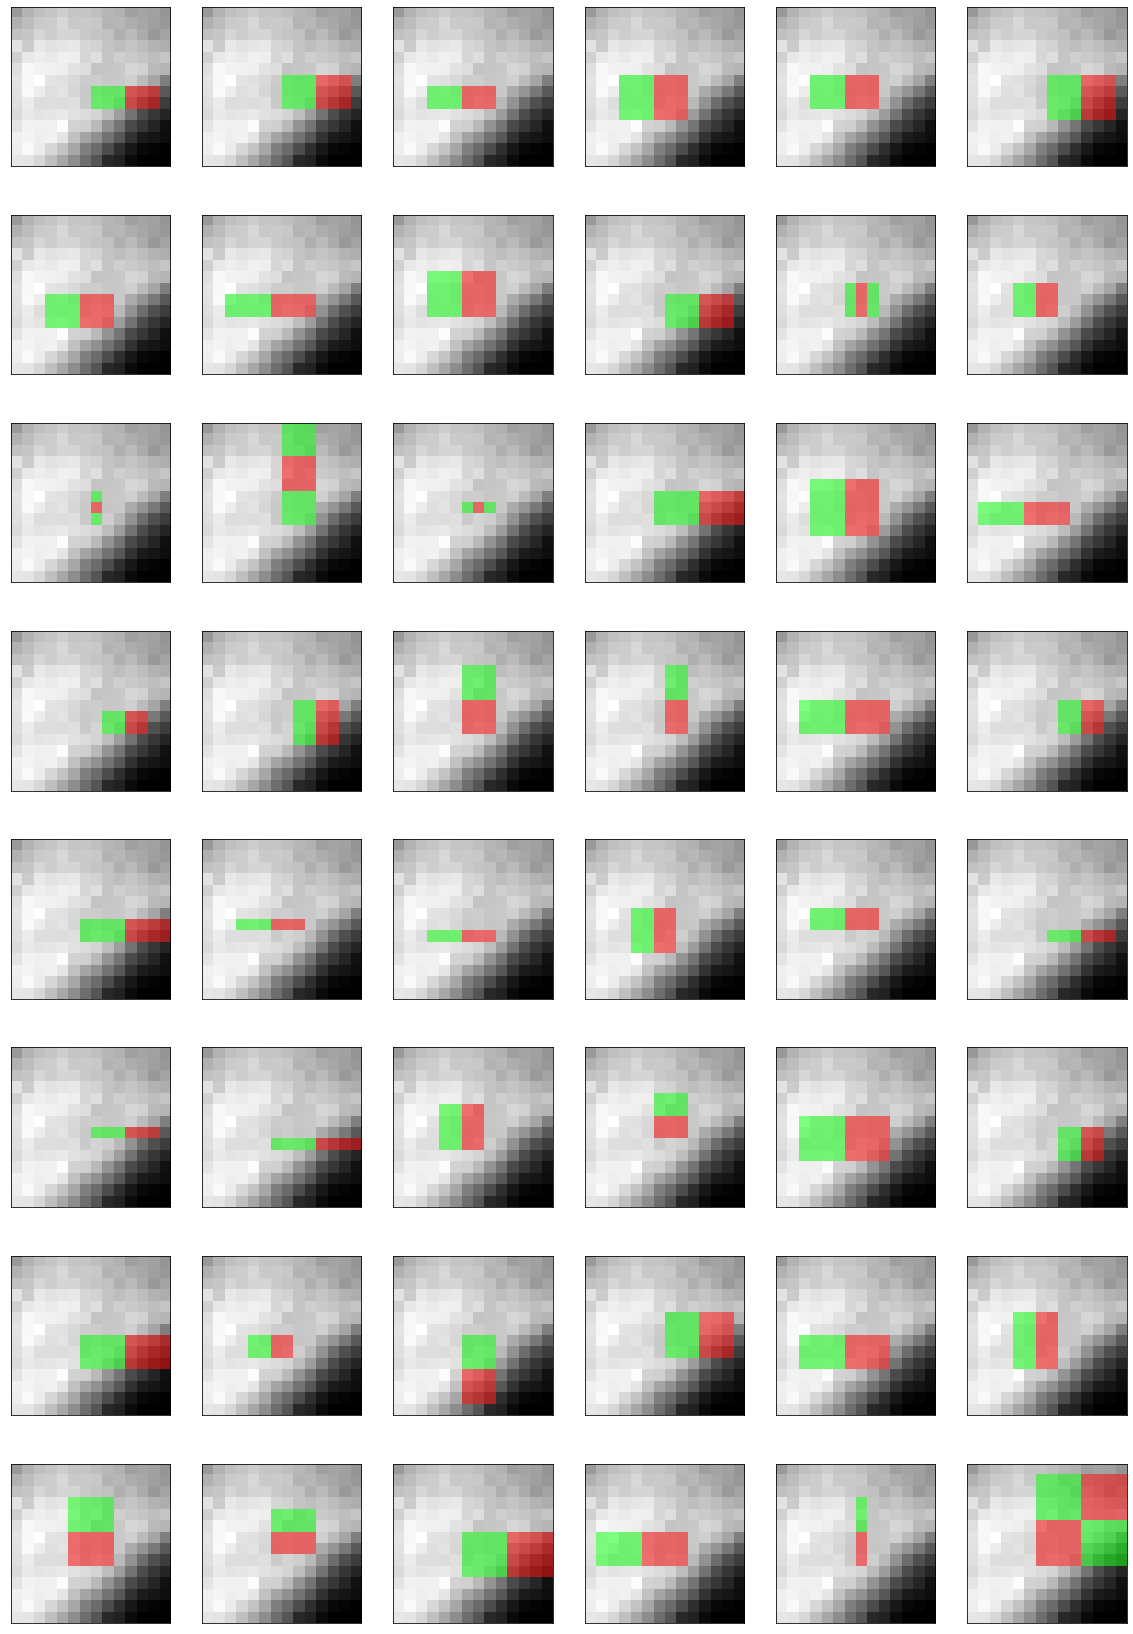

In [33]:
fig, axs = plt.subplots(8, 6, figsize=(20,30))
for idx, ax in enumerate(axs.ravel()):
    img = utils.min_max_norm(images[0], 1.).astype('float')
    img = draw_haar_like_feature(
        img, 0, 0, images.shape[2], images.shape[1], [cfe_sel.skimage_haar_feature_coords[idx]])
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

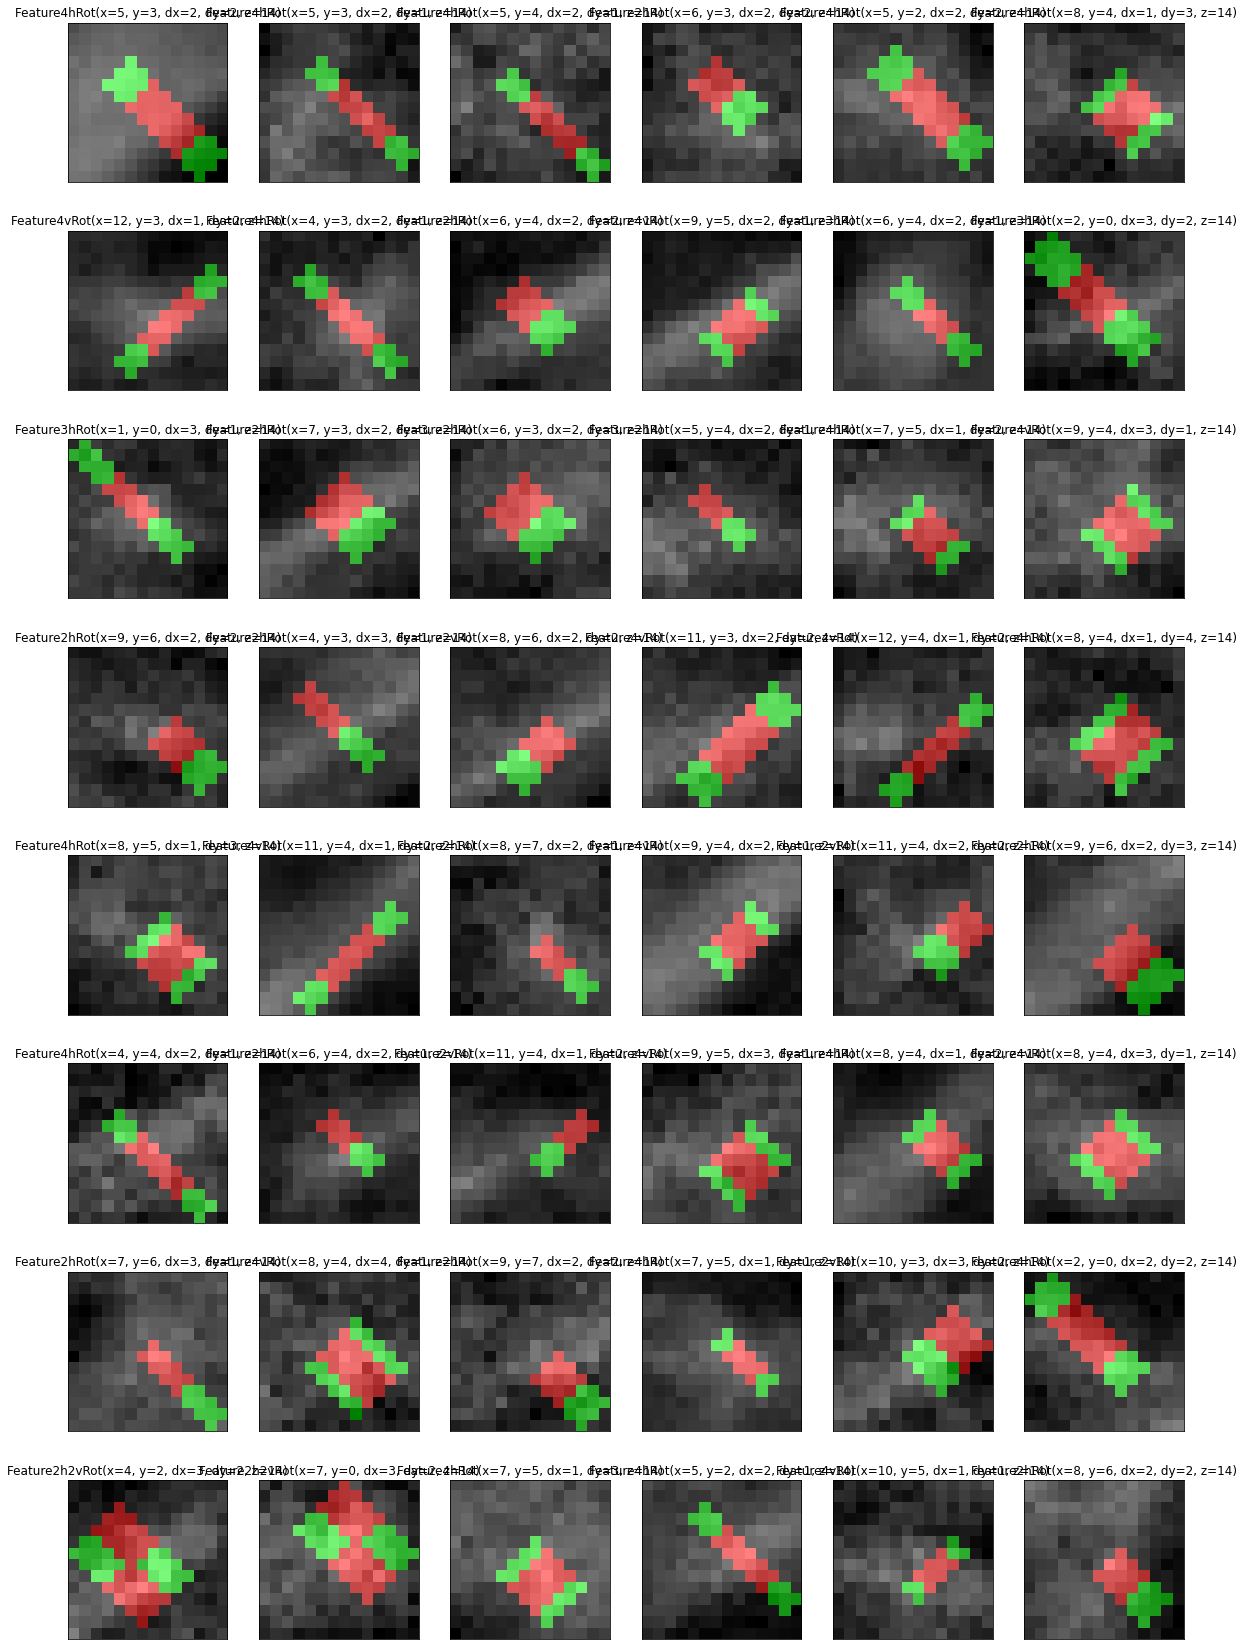

In [34]:
bfig, axs = plt.subplots(8, 6, figsize=(20,30))
for ax, img, feat in zip(np.ravel(axs), images, cfe_sel.our_haar_feature_types_h[:48]):
    image = draw_our_haar_like_features(img, feat, rot=False)
    ax.imshow(image)
    ax.set_title(feat)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

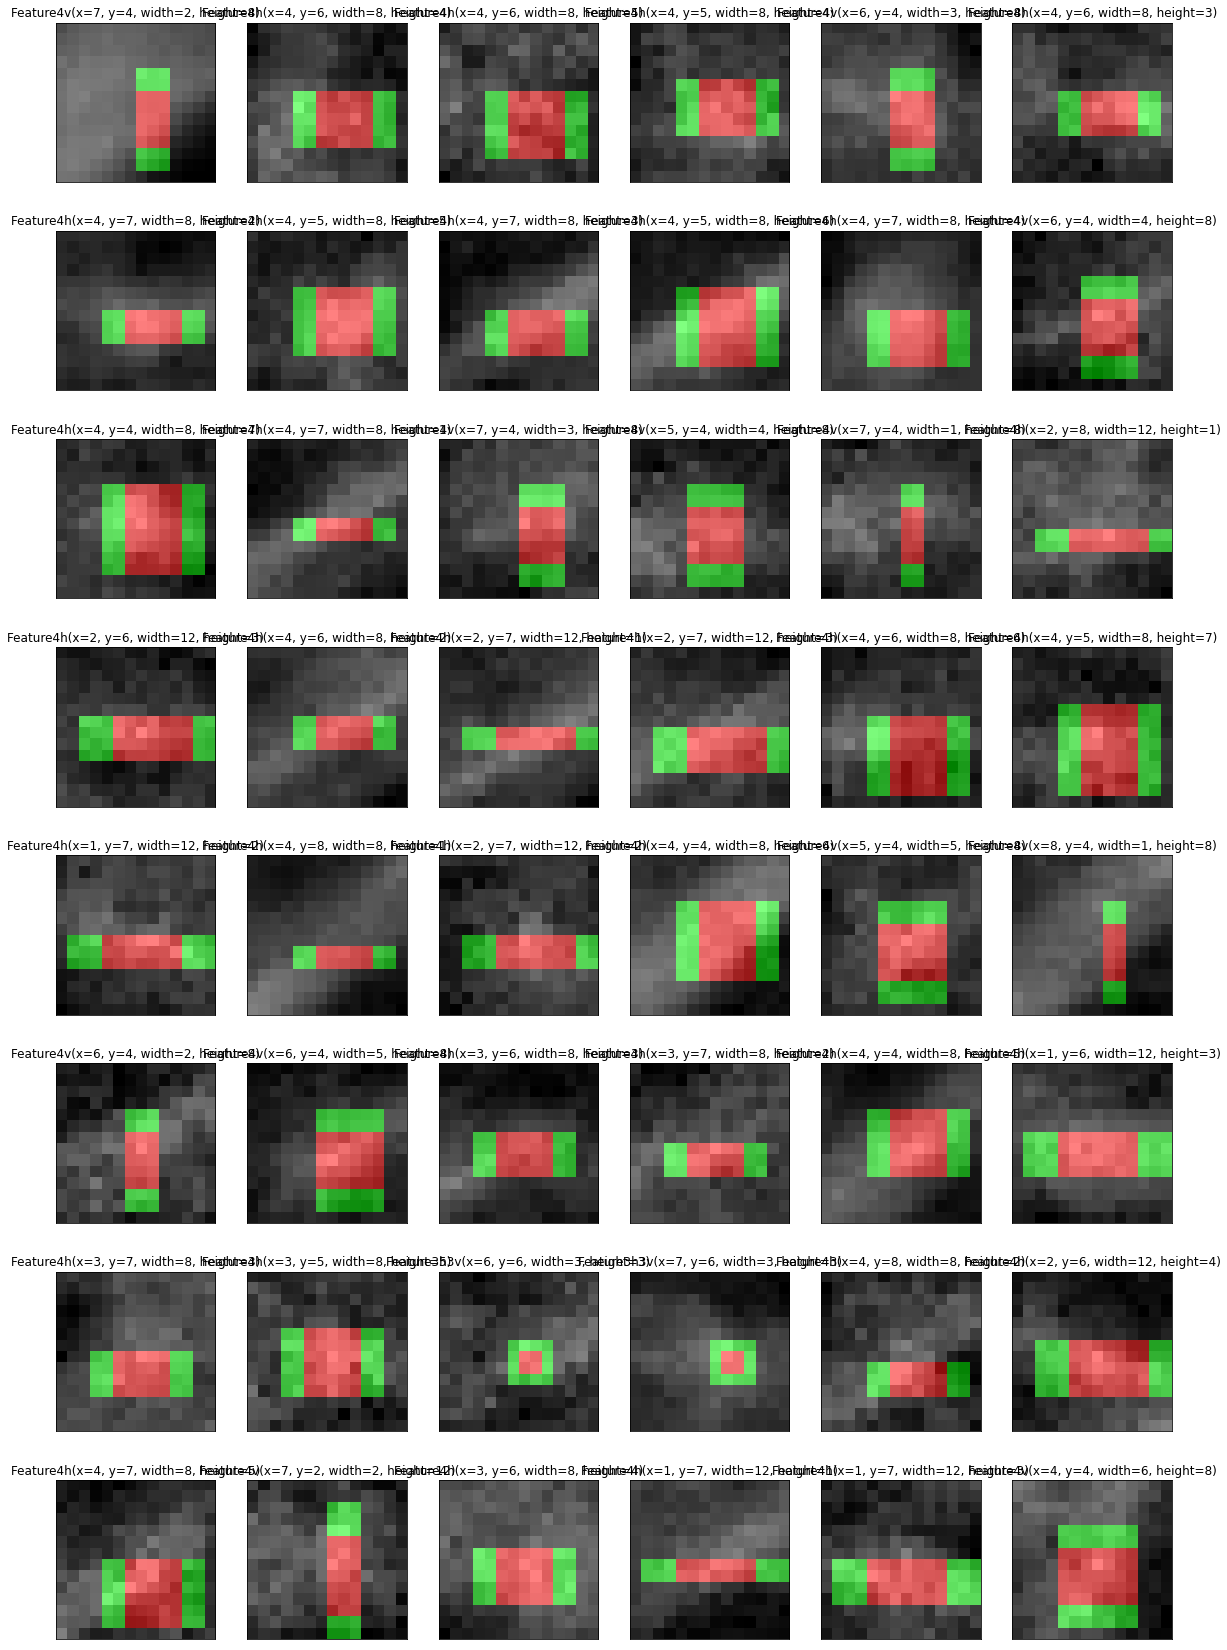

In [35]:
fig, axs = plt.subplots(8, 6, figsize=(20,30))
for ax, img, feat in zip(np.ravel(axs), images, cfe_sel.our_haar_feature_types_r[:48]):
    image = draw_our_haar_like_features(img, feat, rot=False)
    ax.imshow(image)
    ax.set_title(feat)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()